# Generates images from text prompts with CLIP guided diffusion.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses OpenAI's 512x512 class-conditional ImageNet diffusion model (https://github.com/openai/guided-diffusion) together with CLIP (https://github.com/openai/CLIP) to connect text prompts with images. 

In [1]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

Note: This notebook requires 16 GB of GPU memory to work, if you are unable to get a 16 GB GPU consistently, try the [256x256 version](https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj).

In [2]:
# Check the GPU

!nvidia-smi

Sun Aug 15 19:27:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0  On |                  N/A |
| 70%   49C    P5    32W / 290W |    842MiB / 24267MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install dependencies

#!git clone https://github.com/openai/CLIP
#!git clone https://github.com/crowsonkb/guided-diffusion
#!pip install -e ./CLIP
#!pip install -e ./guided-diffusion

In [4]:
# Download the diffusion model

#!curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/512x512_diffusion.pt'

In [5]:
# Imports

import math
import io
import sys
import time

from IPython import display
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

In [6]:
import guided_diffusion
print(guided_diffusion.__file__)

/home/lleonard/dev/perso/taming-transformers/scripts/guided_diffusion_hd/guided-diffusion/guided_diffusion/__init__.py


In [7]:
# Define necessary functions

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


In [8]:
# Model settings

model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': True,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '1000',
    'image_size': 512,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

In [9]:
# Load models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('512x512_diffusion.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])


Using device: cuda:0


## Settings for this run:

In [12]:
prompt = 'A steampunk painting of Darth Vader'
batch_size = 1
clip_guidance_scale = 1000
tv_scale = 150
cutn = 40
cut_pow = 0.5
n_batches = 1
init_image = None
skip_timesteps = 0
seed = None

### Actually do the run...

  0%|          | 0/1000 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


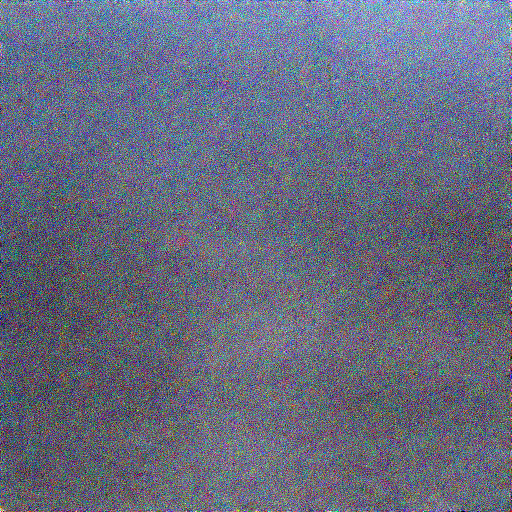

In [ ]:
if seed is not None:
    torch.manual_seed(seed)
else:
    torch.manual_seed(time.time())

text_embed = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()

init = None
if init_image is not None:
    init = Image.open(fetch(init_image)).convert('RGB')
    init = init.resize((model_config['image_size'], model_config['image_size']), Image.LANCZOS)
    init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

make_cutouts = MakeCutouts(clip_size, cutn, cut_pow)

cur_t = None

def cond_fn(x, t, y=None):
    with torch.enable_grad():
        x = x.detach().requires_grad_()
        n = x.shape[0]
        my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
        out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float().view([cutn, n, -1])
        dists = spherical_dist_loss(image_embeds, text_embed.unsqueeze(0))
        losses = dists.mean(0)
        tv_losses = tv_loss(x_in)
        loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale
        return -torch.autograd.grad(loss, x)[0]

if model_config['timestep_respacing'].startswith('ddim'):
    sample_fn = diffusion.ddim_sample_loop_progressive
else:
    sample_fn = diffusion.p_sample_loop_progressive

for i in range(n_batches):
    cur_t = diffusion.num_timesteps - skip_timesteps - 1

    samples = sample_fn(
        model,
        (batch_size, 3, model_config['image_size'], model_config['image_size']),
        clip_denoised=False,
        model_kwargs={'y': torch.zeros([batch_size], device=device, dtype=torch.long)},
        cond_fn=cond_fn,
        progress=True,
        skip_timesteps=skip_timesteps,
        init_image=init,
        randomize_class=True,
    )

    for j, sample in enumerate(samples):
        cur_t -= 1
        if j % 100 == 0 or cur_t == -1:
            print()
            for k, image in enumerate(sample['pred_xstart']):
                filename = f'progress_{i * batch_size + k:05}.png'
                TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                tqdm.write(f'Batch {i}, step {j}, output {k}:')
                display.display(display.Image(filename))
